In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df2 = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)
df2.index.freq='MS'
df = df2.copy()
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df['6MA'] = df['#Passengers'].rolling(window=6).mean()
df['12MA'] = df['#Passengers'].rolling(window=12).mean()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   #Passengers  144 non-null    int64  
 1   6MA          139 non-null    float64
 2   12MA         133 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.5 KB


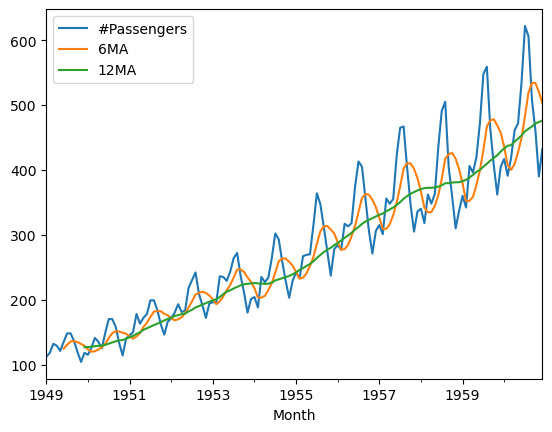

In [5]:
df.plot()
plt.show()

In [6]:
df = df2.copy()
train = df[:120]
test = df[120:]

In [7]:
data = train.copy()

sma = data['#Passengers'].rolling(6).mean()

for i in range(24):
    forecast = sma.iloc[-1]
    last_date = data.index[-1]
    last_date1 = last_date + pd.DateOffset(months=1)
    data.loc[last_date1] = forecast
    sma = data['#Passengers'].rolling(6).mean()

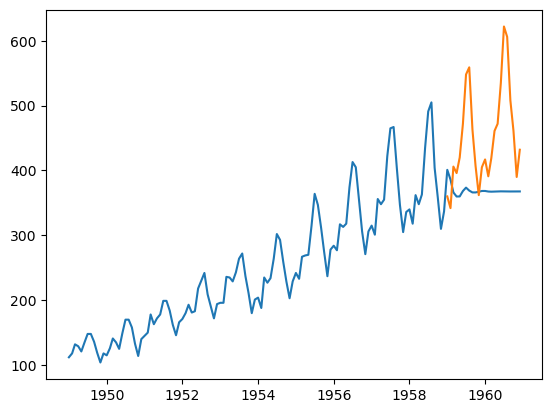

In [8]:
#plt.plot(train)
plt.plot(data)
plt.plot(test)

In [9]:
### Exponential Weighted Moving Average

In [10]:
df['12ewm'] = df['#Passengers'].ewm(span=12, adjust=True).mean()
df['12sma'] = df['#Passengers'].rolling(window=12).mean()

<AxesSubplot: xlabel='Month'>

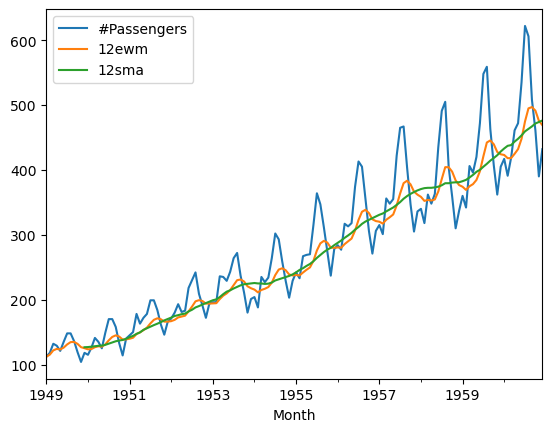

In [11]:
df.plot()

In [12]:
### Simple Exponential Smoothing

In [13]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [14]:
df = df2.copy()
train = df[:120]
test = df[120:]

In [15]:
fit1 = SimpleExpSmoothing(train).fit()
pred = fit1.forecast(24)

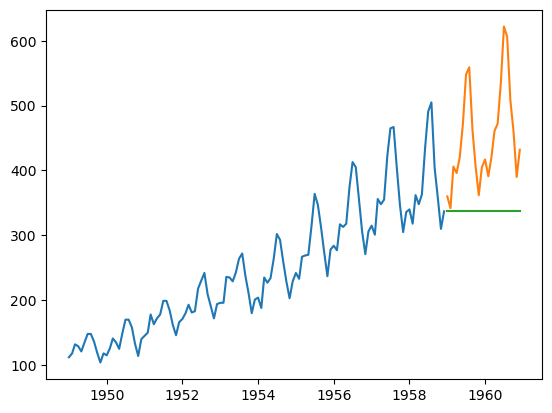

In [16]:
plt.plot(train)
plt.plot(test)
plt.plot(pred)

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [18]:
df = df2.copy()
train = df[:120]
test = df[120:]

In [19]:
hw = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12).fit()
pred = hw.forecast(24)

E:\anaconda\envs\py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


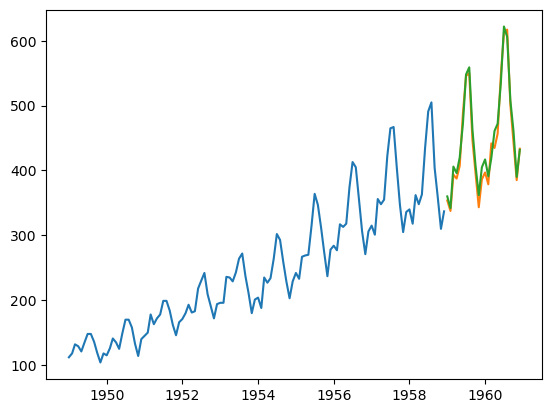

In [20]:
plt.plot(train)
plt.plot(pred)
plt.plot(test)

In [21]:
### Residual Analysis

In [22]:
train = train.copy()
train.loc[:,'pred'] = hw.fittedvalues
train.loc[:,'residuals'] = hw.resid

In [23]:
train.describe()

,#Passengers,pred,residuals
count,120.000000,120.000000,120.000000
mean,245.908333,245.832482,0.075852
std,94.942087,94.634684,9.528605
min,104.000000,106.308674,-24.318201
25%,170.750000,166.919452,-4.453788
50%,233.500000,229.360263,-0.309541
75%,313.500000,314.785229,5.555680
max,505.000000,479.224012,25.985039


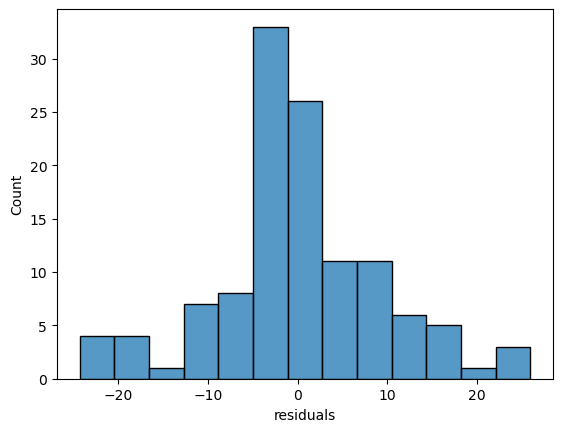

In [24]:
sns.histplot(train['residuals'])
plt.show()

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### ARIMA process

In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
df = df2.copy()

adf = adfuller(df)
adf = pd.Series(adf, index=['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'res', 'res2'])
adf

Test Statistic                                                          0.815369
p-value                                                                  0.99188
#Lags Used                                                                    13
Number of Observations Used                                                  130
res                            {'1%': -3.4816817173418295, '5%': -2.884041834...
res2                                                                  996.692931
dtype: object

In [28]:
df['diff1'] = df['#Passengers'].diff()
df['diff2'] = df['#Passengers'].diff(2)
df = df.dropna()

In [29]:
adf = adfuller(df['diff1'])
print('Test stat', adf[0], '\n', 'p-value', adf[1])

Test stat -2.833425645565336 
 p-value 0.053655499158907397


In [30]:
adf = adfuller(df['diff2'])
print('Test stat', adf[0], '\n', 'p-value', adf[1])

Test stat -2.9616951355554337 
 p-value 0.03862975767698741


In [31]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [32]:
df = df2.copy()
train = df[:120]
test = df[120:]

In [33]:
model = ARIMA(train, order=(1, 1, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -559.714
Date:                Thu, 01 Jun 2023   AIC                           1125.429
Time:                        10:18:14   BIC                           1133.766
Sample:                    01-01-1949   HQIC                          1128.814
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5120      0.148     -3.469      0.001      -0.801      -0.223
ma.L1          0.8746      0.097      8.977      0.000       0.684       1.066
sigma2       709.3300     83.383      8.507      0.000     545.903     872.757
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 3.60
Prob(Q):                              0.69   Prob(JB):                         0.16
Heteroskedasticity (H):               6.95   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(24)

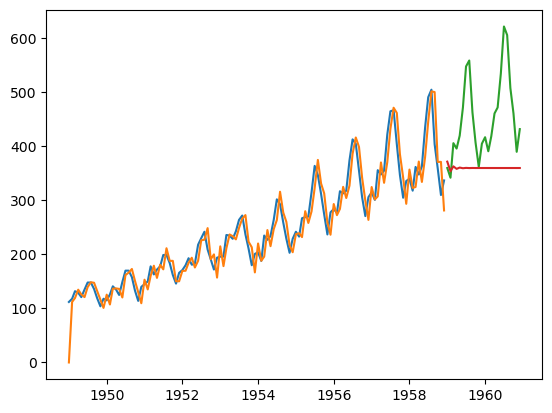

In [35]:
plt.plot(train)
plt.plot(train_pred)
plt.plot(test)
plt.plot(test_pred)

In [36]:
train_mse =  mean_squared_error(train, train_pred)
print('train_mse', train_mse)
test_mse = mean_squared_error(test, test_pred)
print('test_mse', test_mse)

train_mse 808.3658348907933
test_mse 14076.523846608174


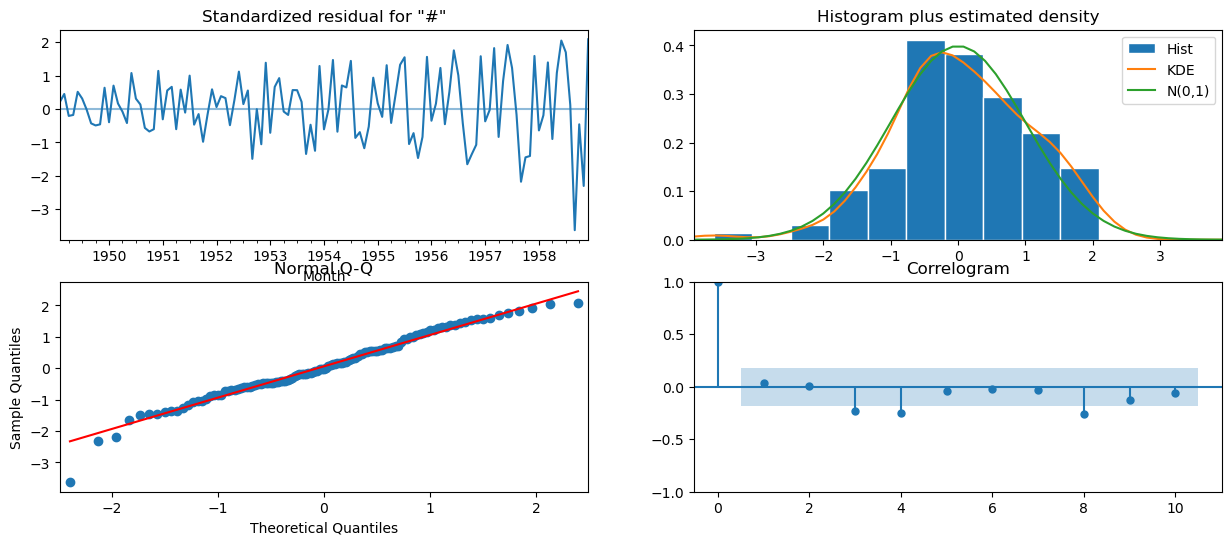

In [37]:
results.plot_diagnostics(figsize=(15,6))
plt.show()

In [38]:
from itertools import product
n = [0,1,2]
order = list(product(n, repeat=3))
best_mse=np.inf
best_order=''

for ord in order:
    try:
        model = ARIMA(train, order=ord).fit()
        testf = model.forecast(24)
        mse = round(mean_squared_error(test, testf),4)
        print(ord, '    mse: ', mse)
        if mse < best_mse:
            best_mse=mse
            best_order=ord
    except:
        print(ord, '  failed')
        continue
print('best mse', best_mse, 'best order', best_order)   

(0, 0, 0)     mse:  48153.5768
(0, 0, 1)     mse:  47547.1326
(0, 0, 2)     mse:  47870.4427
(0, 1, 0)     mse:  18859.25
(0, 1, 1)     mse:  15201.0017
(0, 1, 2)     mse:  14222.6331
(0, 2, 0)     mse:  79134.5
(0, 2, 1)     mse:  13396.8113
(0, 2, 2)     mse:  10280.0673
(1, 0, 0)     mse:  30594.2392
(1, 0, 1)     mse:  32572.3781
(1, 0, 2)     mse:  29568.9834
(1, 1, 0)     mse:  16490.0375
(1, 1, 1)     mse:  14076.5238
(1, 1, 2)     mse:  11644.3065
(1, 2, 0)     mse:  11560.4835
(1, 2, 1)     mse:  11364.8472
(1, 2, 2)     mse:  9304.6413
(2, 0, 0)     mse:  34811.2719
(2, 0, 1)     mse:  28926.7573
(2, 0, 2)     mse:  30446.9618
(2, 1, 0)     mse:  15315.1043
(2, 1, 1)     mse:  10532.3383
(2, 1, 2)     mse:  8226.6876
(2, 2, 0)     mse:  15514.8519
(2, 2, 1)     mse:  10319.2862
(2, 2, 2)     mse:  8965.8888
best mse 8226.6876 best order (2, 1, 2)


In [39]:
model = ARIMA(train, order=(2, 1, 2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  120
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -541.534
Date:                Tue, 30 May 2023   AIC                           1093.069
Time:                        16:01:27   BIC                           1106.965
Sample:                    01-01-1949   HQIC                          1098.711
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6570      0.030     55.581      0.000       1.599       1.715
ar.L2         -0.9068      0.027    -33.742      0.000      -0.959      -0.854
ma.L1         -1.8844      0.058    -32.403      0.000      -1.998      -1.770
ma.L2          0.9852      0.061     16.078      0.000       0.865       1.105
sigma2       497.3919     69.244      7.183      0.000     361.677     633.107
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.41   Prob(JB):                         0.97
Heteroskedasticity (H):               5.95   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(24)

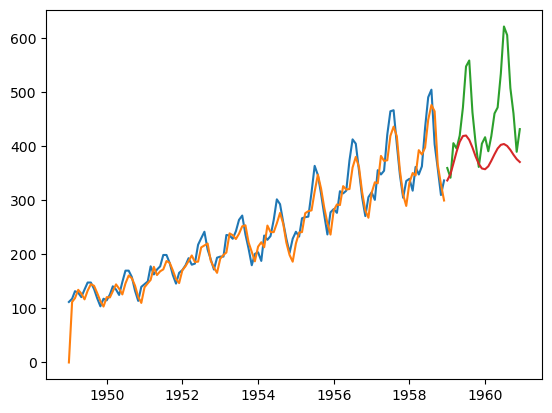

In [41]:
plt.plot(train)
plt.plot(train_pred)
plt.plot(test)
plt.plot(test_pred)

In [42]:
from itertools import product
best_mse = np.inf
best_ord = ''

n = [0,1,2]
order1 = list(product(n, repeat=3))
order2 = list(product(n, repeat=3))
cnt=0
for ord1 in order1:
    for ord2 in order2:
        cnt+=1
        ord2 = ord2+(12,)
        try:
            model = SARIMAX(train, order=ord1, seasonal_order=ord2, trend='c').fit()
            testf = model.forecast(24)
            mse = mean_squared_error(test, testf)
            if mse<best_mse:
                best_mse=mse
                best_ord = ord1 + ord2
                print(cnt, ord1, ord2, mse)
        except:
            print(cnt, ord1, ord2, '   failed')
            continue
print(best_mse, 'order   ', best_ord)       

1 (0, 0, 0) (0, 0, 0, 12) 48153.57090277775
2 (0, 0, 0) (0, 0, 1, 12) 37574.27970090919
3 (0, 0, 0) (0, 0, 2, 12) 26074.908508464763
4 (0, 0, 0) (0, 1, 0, 12) 1208.34705075446
8 (0, 0, 0) (0, 2, 1, 12) 583.9355842583021
9 (0, 0, 0) (0, 2, 2, 12) 153.21786904015164
209 (0, 2, 1) (2, 0, 1, 12)    failed
451 (1, 2, 1) (2, 0, 0, 12)    failed
577 (2, 1, 0) (1, 0, 0, 12)    failed
696 (2, 2, 1) (2, 0, 2, 12)    failed
153.21786904015164 order    (0, 0, 0, 0, 2, 2, 12)


In [47]:
model = SARIMAX(train, order=(0, 0, 0), seasonal_order=(0,2,2,12), trend='c')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                   #Passengers   No. Observations:                  120
Model:             SARIMAX(0, 2, [1, 2], 12)   Log Likelihood                -410.825
Date:                       Tue, 30 May 2023   AIC                            829.650
Time:                               16:13:56   BIC                            839.908
Sample:                           01-01-1949   HQIC                           833.797
                                - 12-01-1958                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9171      0.371      5.171      0.000       1.190       2.644
ma.S.L12      -1.6477    397.604     -0.004      0.997    -780.937     777.641
ma.S.L24       0.6479    257.406      0.003      0.998    -503.858     505.154
sigma2       177.8956   7.07e+04      0.003      0.998   -1.38e+05    1.39e+05
===================================================================================
Ljung-Box (L1) (Q):                  54.05   Jarque-Bera (JB):                 5.60
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               3.78   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(24)

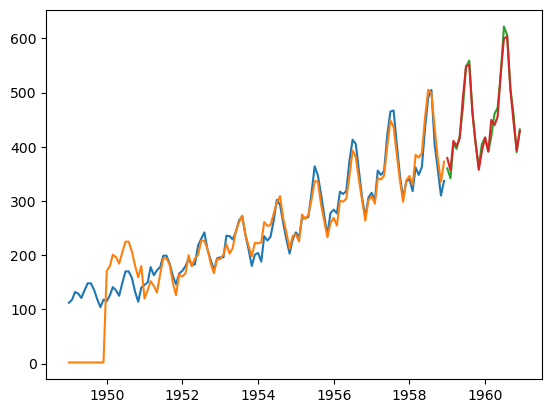

In [49]:
plt.plot(train)
plt.plot(train_pred)
plt.plot(test)
plt.plot(test_pred)

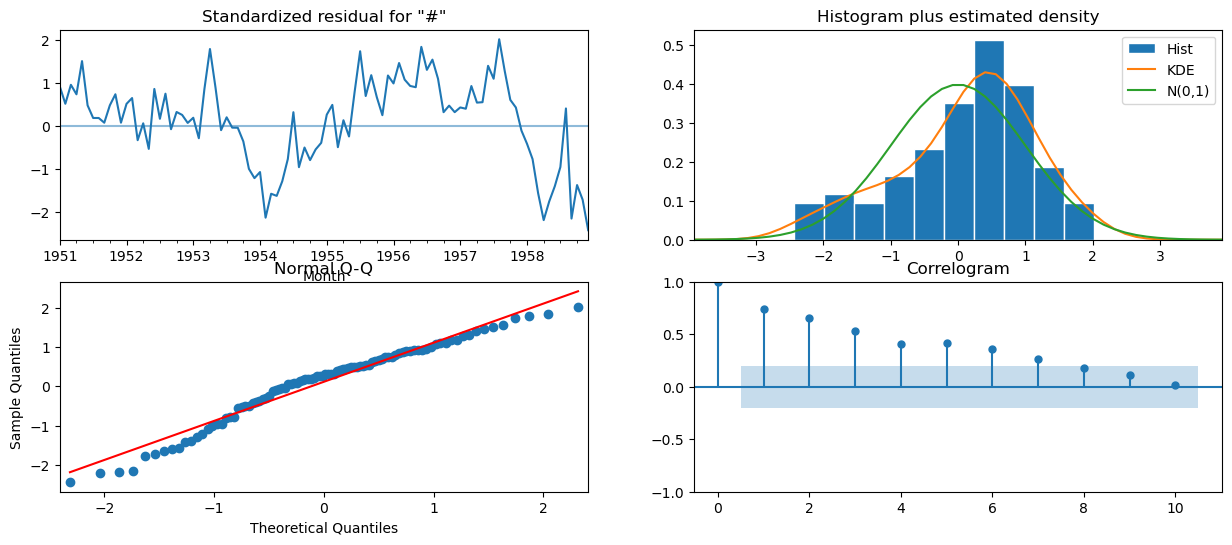

In [50]:
results.plot_diagnostics(figsize=(15,6))
plt.show()

In [44]:
df = df2.copy()
train = df[:120]
test = df[120:]

In [45]:
### Auto ARIMA

from pmdarima import auto_arima

In [46]:
auto_model = auto_arima(train, 
    start_p=0, d=None, start_q=0, 
    max_p=2, max_d=2, max_q=2,
    start_P=0, D=None, start_Q=0, 
    max_P=2, max_D=2, max_Q=2,
    max_order=6, m=12, stepwise=True, trace=True)

auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=0.35 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.08 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=0.64 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.09 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=0.41 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.24 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.16 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=809.448, Time=0.19 sec
 ARIMA(2,0,0)(0,1,0)[12]             : AIC=812.240, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,1,0)[12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.431
Date:                            Tue, 30 May 2023   AIC                            808.863
Time:                                    07:51:19   BIC                            819.592
Sample:                                         0   HQIC                           813.213
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2859      2.035      2.106      0.035       0.297       8.275
ar.L1          0.6783      0.100      6.816      0.000       0.483       0.873
ar.L2          0.1550      0.096      1.609      0.108      -0.034       0.344
sigma2        96.2826     11.855      8.121      0.000      73.046     119.519
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.93   Prob(JB):                         0.44
Heteroskedasticity (H):               1.41   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
model = SARIMAX(train, order=(2, 0, 0), seasonal_order=(0,1,0,12), trend='c')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.431
Date:                            Tue, 30 May 2023   AIC                            808.863
Time:                                    06:58:05   BIC                            819.592
Sample:                                01-01-1949   HQIC                           813.213
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2859      2.035      2.106      0.035       0.297       8.275
ar.L1          0.6783      0.100      6.816      0.000       0.483       0.873
ar.L2          0.1550      0.096      1.609      0.108      -0.034       0.344
sigma2        96.2826     11.855      8.121      0.000      73.046     119.519
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.93   Prob(JB):                         0.44
Heteroskedasticity (H):               1.41   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(24)

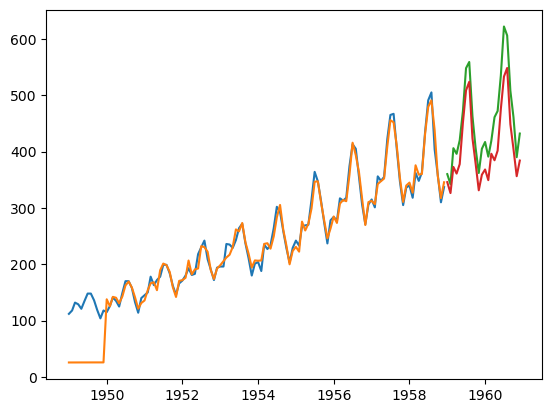

In [55]:
plt.plot(train)
plt.plot(train_pred)
plt.plot(test)
plt.plot(test_pred)

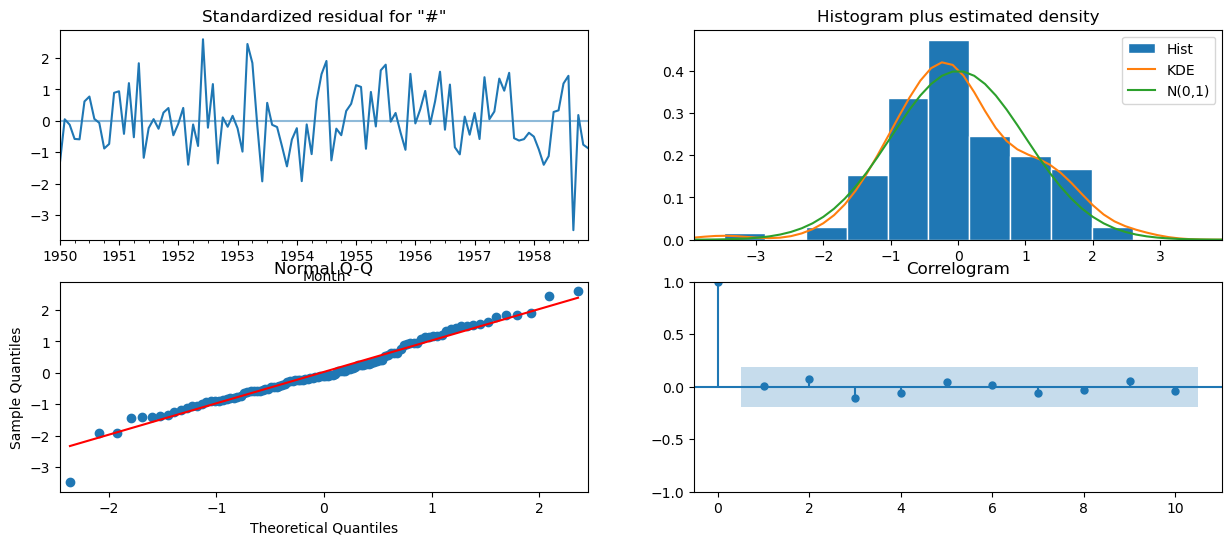

In [56]:
results.plot_diagnostics(figsize=(15,6))
plt.show()